# QieList

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("../")

## Building Sampling Frame

### Idiom List (in ngrams)

In [2]:
import local_config
import pickle
from functools import partial, reduce
import pandas as pd
import numpy as np
from MWE2019.materials import NGram4List, MoeIdioms
from MWE2019.corpus import CorpusFactory
from MWE2019.corpus_index import CorpusIndex
from MWE2019.utils import get_cache_path, install_data_cache
from tqdm import tqdm_notebook as tqdm

In [3]:
ng = NGram4List()

NGram4List loaded:  E:\LangOn\MWE2019\data\cache_ngrams_list\ngrams_var_list.csv


In [4]:
idioms = MoeIdioms()

initialize new instance


In [5]:
ng.merged_df.head()

,freq,sub2.A,del2.A,sub3.A,del3.A,ins.A,sub2.C,del2.C,sub3.C,del3.C,ins.C,sub2.P,del2.P,sub3.P,del3.P,ins.P,pmi
ngram,,,,,,,,,,,,,,,,,
台北報導,206875,244,2,0,0,22,233,0,0,0,6,0,0,0,0,0,-46.299180
資料來源,121438,15,0,0,0,16,4,0,0,0,1,0,0,0,0,0,-44.669832
綜合報導,112063,0,0,0,0,308,0,0,0,0,59,0,0,0,0,0,-43.862106
中華民國,58360,3,0,8,11,55,2,0,1,2,26,2,0,1,0,51,-48.729690
最重要的,35402,38,0,16,11,33,28,0,6,1,20,61,1,9,2,98,-51.222036


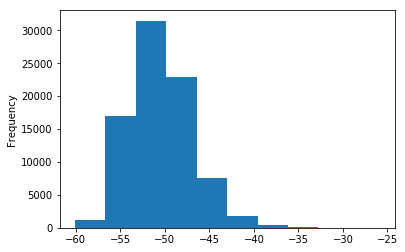

In [6]:
ng.merged_df.pmi.plot(kind='hist')

In [7]:
enc_seeds = ng.merged_df.sort_values("pmi", ascending=False).iloc[:int(ng.merged_df.shape[0]/2), :].reset_index()["ngram"]
enc_seeds = enc_seeds.loc[('?' not in x for x in enc_seeds)]
install_data_cache('enclosing_ngrams')
seed_path = get_cache_path('enclosing_ngrams', f"enclosing_seed.csv")
enc_seeds.to_csv(seed_path, index=False)


## merging enclosings

In [9]:
from MWE2019.materials import compute_enclosing

In [10]:
enc_df = compute_enclosing(ng.merged_df)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("sub")], inplace=True)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("del")], inplace=True)
enc_df.drop(columns=[x for x in enc_df.columns if x.startswith("ins")], inplace=True)
enc_df = enc_df.loc[enc_df.enc_freq > 0]

In [11]:
enc_df["enc_norm"] = np.log(enc_df.enc_freq/enc_df.freq)

In [12]:
enc_df["enc_norm_pr"] = enc_df.enc_norm.rank(ascending=False, pct=True)
enc_df["pmi_pr"] = enc_df.pmi.rank(pct=True)
enc_df = enc_df.loc[(enc_df.enc_norm_pr>=0.75) & (enc_df.pmi_pr >= 0.75), :]
qie_df = enc_df.loc[(x for x in enc_df.index if x not in idioms), :]
qie_df.index.name = "ngram"

In [13]:
print(enc_df.shape)
print(qie_df.shape)

(2722, 6)
(2478, 6)


In [14]:
install_data_cache("qie_list")
qie_path = get_cache_path("qie_list", "qie_list.csv")
qie_df.to_csv(qie_path, index=True)

## Generate QieContext Sentences

In [15]:
from MWE2019.materials import QieContext
from itertools import islice, chain
from collections import defaultdict

In [16]:
ptt = CorpusFactory.GetPttCorpus(local_config.CORPUS_DIR + "/PTT")
ctimes = CorpusFactory.GetNewsCorpus(local_config.CORPUS_DIR + "/China_text")
apple = CorpusFactory.GetNewsCorpus(local_config.CORPUS_DIR + "/Apple_text")

In [17]:
artN = 80e4+70e4+11e4
# art_iter = islice(all_iter, 10)

In [26]:
len(qie_df.index.values.tolist() + list(idioms))

7584

In [ ]:
qie_context = defaultdict(set)
sample_ratio = 0.001
seeds = qie_df.index.values.tolist() + list(idioms)
loop_counter = 0

while len(seeds) > 0:
    print(f"finding context of {len(seeds)}")
    print(f"sampling ratio: {sample_ratio}")
    print(f"finding in {int(artN * sample_ratio)} articles")
    all_iter = chain(ptt.articles(), ctimes.articles(), apple.articles())
    art_iter = filter(lambda x: x[0] % int(1/sample_ratio) == 0, all_iter)
    ctx = QieContext(art_iter)
    batch = ctx.search_context(seeds)
    for ngram, ctxlist in batch.items():
        qie_context[ngram].update(batch[ngram])
    
    if sample_ratio >= 1:
        break
    else:
        seeds = [ngram_x for ngram_x, ctxlist in qie_context.items() if len(ctxlist) <= 5]
        sample_ratio = min(sample_ratio * 1.9, 1)
    

finding context of 7584
sampling ratio: 0.001
finding in 1610 articles



finding context of 7426
sampling ratio: 0.0019
finding in 3059 articles



finding context of 6724
sampling ratio: 0.00361
finding in 5812 articles



finding context of 5646
sampling ratio: 0.006859
finding in 11042 articles



finding context of 4563
sampling ratio: 0.013032099999999998
finding in 20981 articles



finding context of 3905
sampling ratio: 0.024760989999999993
finding in 39865 articles



finding context of 3725
sampling ratio: 0.047045880999999984
finding in 75743 articles



finding context of 3613
sampling ratio: 0.08938717389999996
finding in 143913 articles



finding context of 3543
sampling ratio: 0.1698356304099999
finding in 273435 articles


In [ ]:
install_data_cache("qie_list")
qie_context_path = get_cache_path("qie_list", "qie_context.pkl")
with open(qie_context_path, "wb") as fout:
    pickle.dump(qie_context, fout)

## Compute exact frequency

In [137]:
from itertools import chain, islice
from collections import Counter

ngram_freq = Counter()
ngrams = qie_df.index.values

In [ ]:
# took around ~60 minutes, in i7 single process
all_iter = chain(ptt.articles(), ctimes.articles(), apple.articles())
# all_iter = islice(all_iter, 1000)
for _, _, art_x in tqdm(all_iter):
    ngram_freq.update({ng: art_x.count(ng) for ng in ngrams})  


In [150]:
exact_freq_df = pd.DataFrame.from_dict(ngram_freq, orient='index', columns=['exact_freq'])
qie_full = qie_df.join(exact_freq_df)
qie_full_path = get_cache_path("qie_list", "qie_list.csv")
qie_full.to_csv(qie_full_path, index=True)

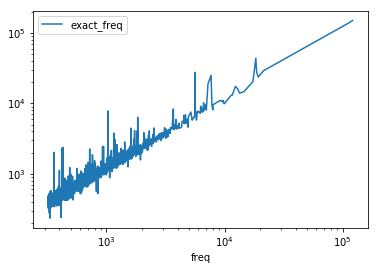

In [148]:
qie_full.plot('freq', 'exact_freq', logx=True, logy=True)

In [161]:
(np.log(qie_full.loc[:,["freq", "exact_freq"]])).corr()

,freq,exact_freq
freq,1.000000,0.978241
exact_freq,0.978241,1.000000


### Idioms exact frequency

In [ ]:
idiom_freq = Counter()
idiom_list = list(idioms)
# took around ~60 minutes, in i7 single process
all_iter = chain(ptt.articles(), ctimes.articles(), apple.articles())
# all_iter = islice(all_iter, 1000)
for _, _, art_x in tqdm(all_iter):
    idiom_freq.update({idiom_x: art_x.count(idiom_x) for idiom_x in idiom_list})  


In [ ]:
install_data_cache("qie_list")
idiom_freq_path = get_cache_path("qie_list", "idiom_exact_frequency.pkl")
with open(idiom_freq_path, "wb") as fout:
    pickle.dump(idiom_freq, fout)